In [46]:
import pathlib

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM

from common import *

In [41]:
# read in all the data
df = pd.concat(pd.read_csv(dataset, sep="\t") for dataset in GOOGLE_AUDIO_DATASETS)
df

,segment_id,start_time_seconds,end_time_seconds,label
0,s9d-2nhuJCQ_30000,0.000,10.000,/m/04rlf
1,s9d-2nhuJCQ_30000,2.627,7.237,/m/053hz1
2,s9d-2nhuJCQ_30000,2.627,9.239,/m/03qtwd
3,s9d-2nhuJCQ_30000,5.634,6.649,/m/01w250
4,s9d-2nhuJCQ_30000,7.201,8.560,/m/0l15bq
...,...,...,...,...
934816,cq-vfngNXMc_70000,7.836,8.015,/m/07qjznt
934817,cq-vfngNXMc_70000,8.226,8.511,/t/dd00099
934818,cq-vfngNXMc_70000,8.503,8.868,/m/05zppz
934819,cq-vfngNXMc_70000,9.217,9.624,/t/dd00099


In [42]:
chainsaw_id = pd.read_csv(MID_TO_NAME_PATH, sep="\t", names=["mid", "name"]).query("name == 'Chainsaw'")["mid"].iloc[0]
chainsaw_id

'/m/01j4z9'

In [4]:
# select only chainsaw labelled audios and ignore rTKuABX5LJ4_260000 (incorrectly labelled)
chainsaw_audios = df.query(f"(label=='{chainsaw_id}') & (segment_id != 'rTKuABX5LJ4_260000')").drop(columns="label")
chainsaw_audios

,segment_id,start_time_seconds,end_time_seconds
4096,BBukw6JpCeg_70000,0.008,10.0
8904,KwwcpaxWT5E_30000,5.976,10.0
9128,W1VYWwYdJRQ_370000,0.000,10.0
10865,CZQ1bedI5Wo_80000,0.000,10.0
12825,Vsz6dpRCwSo_380000,0.000,10.0
...,...,...,...
906217,nWbsJOxO-34_80000,7.149,10.0
921729,9qmCbAoykkQ_40000,0.000,10.0
926011,93C94T6TfhA_0,5.402,10.0
928667,VbpHhTTiEfk_30000,0.000,10.0


In [5]:
import warnings
warnings.filterwarnings('ignore')

audio = [librosa.load(CHAINSAW_AUDIO_DIR / f"{segment_id}.mp3", offset=start_time, duration=end_time-start_time)[0]
         for segment_id, start_time, end_time in chainsaw_audios.to_records(index=False)]

In [6]:
sample_duration = 1 / 22050
f"{sample_duration:6f} seconds per sample"

'0.000045 seconds per sample'

In [7]:
FRAME_LENGTH = 8192
HOP_LENGTH = 4096

In [8]:
FRAME_LENGTH * sample_duration   # frame length in seconds

0.37151927437641724

In [9]:
def amplitude_envelope(signal, frame_length, hop_length):
    return np.array([np.max(signal[i:i+frame_length]) for i in range(0, len(signal), hop_length)])

In [10]:
# amplitude envelope
aes = [amplitude_envelope(a, FRAME_LENGTH, HOP_LENGTH) for a in audio]

In [11]:
# root mean square energy
rms = [librosa.feature.rms(a, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0] for a in audio]

In [12]:
# zero crossing rate
zcr = [librosa.feature.zero_crossing_rate(a, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0] for a in audio]

In [20]:
# mel-frequency cepstrum coefficient
mfcc = [librosa.feature.mfcc(a, n_mfcc=13) for a in audio]

In [22]:
aes[0].shape, rms[0].shape, zcr[0].shape, mfcc[0].shape

((54,), (54,), (54,), (13, 431))

In [23]:
audio[0].shape

(220324,)

In [25]:
# extract short time fourier transform
stft = [librosa.stft(a, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH) for a in audio]

In [26]:
stft[0].shape

(4097, 54)

In [29]:
# spectral centroid
sc = [librosa.feature.spectral_centroid(a, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0] for a in audio]

In [30]:
sc[0].shape

(54,)

In [31]:
# spectral bandwidth
sb = [librosa.feature.spectral_bandwidth(a, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0] for a in audio]

In [32]:
sb[0].shape

(54,)

In [43]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y,
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

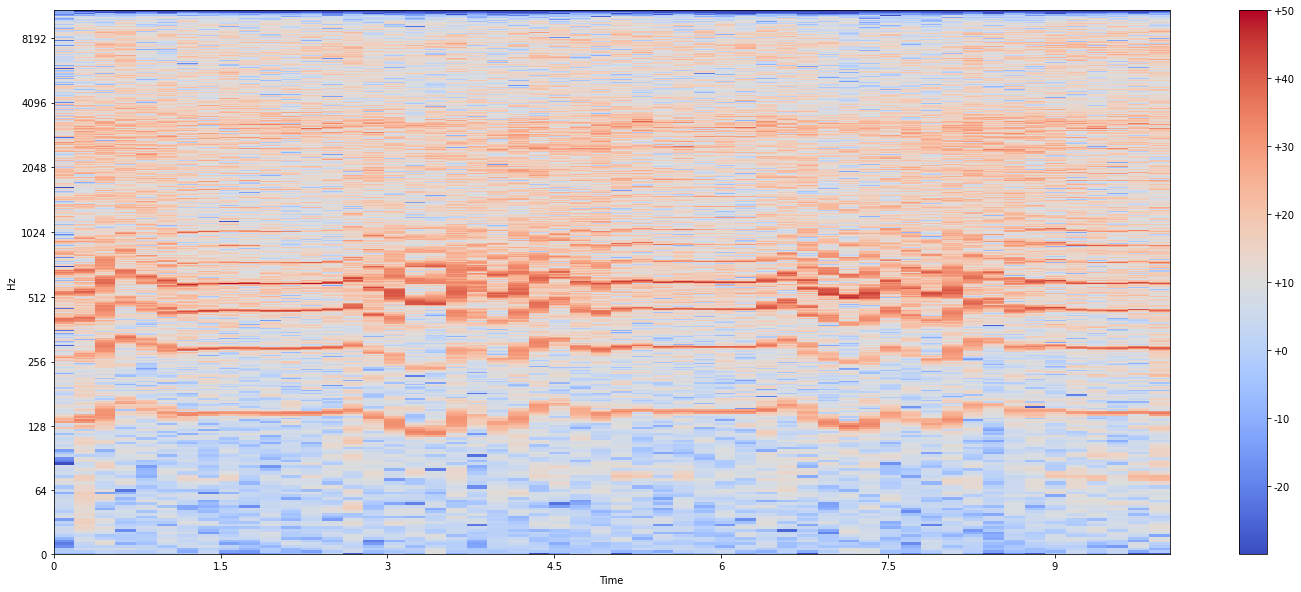

In [94]:
Y = librosa.power_to_db(np.abs(stft[400]) ** 2)
plot_spectrogram(Y, 22050, HOP_LENGTH, y_axis="log")